# **Segmentacija nervnih struktura UNET neuronskom mrežom** 

**Uvod:**

Cilj ovog projekta je prepoznavanje nervnih struktura na slikama dobijenim ultrazvukom ljudskog vrata. To prepoznavanje pomaže prilikom medicinskih intervencija, kako bi se minimalizovao bol kod pacijenata tokom tih intervencija tako što će se izbegavati nervne strukture detektovane neuronskom mrežom koja je predstavljena u ovom projektu. 

Za izradu projekta koristiće se UNET arhitektura. Nju je razvio Olaf Ronneberger za segmentaciju biomedinciskih fotografija, 2015. godine na Univerzitetu u Frajburgu, Nemačka. Reč je o konvolucionalnoj neuronskoj mreži (sadrži samo nivoe konvolucije, ne sadrži "dense" nivoe), što omogućava rešavanje kompleksnih prepoznavanja obrazaca na osnovu slika. Pokazala je bolje performanse od prethodne arhitekture za ovu namenu ("sliding-window setup"), i osvojila je mnoge nagrade. Konkretno, prednost UNET arhitekture je u tome što joj je potreban manji broj slika, i moguće je napraviti preciznije segmetnacije. Iz tog razloga je UNET arhitektura izabrana za rešavanje problema u okviru ovog projekta. 



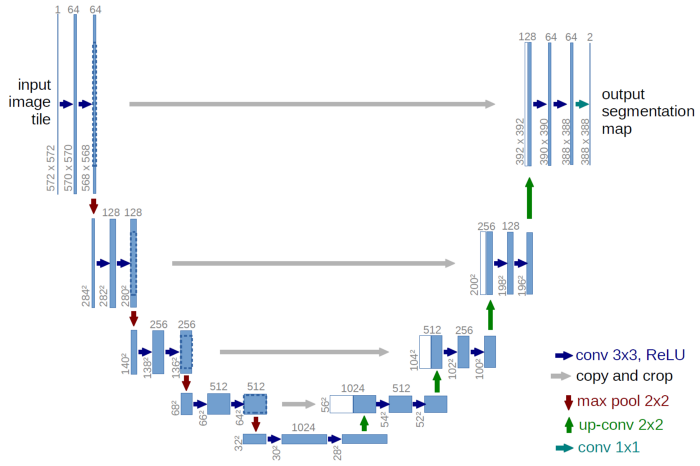

Cilj konvolucionalnih neuronskih mreža u oblasti biomedinice jeste da klasifikuje piksele, odnosno da se pikselima dodeli neki "class label". Na osnovu toga se pravi maska slike, koja govori gde je objekat koji se traži lociran na slici (kao i njegove dimenzije).

Ulazni podaci se propagiraju kroz mrežu svim mogućim putanjama, kao što je prikazano na slici UNET arhitekture iznad, i kao rezultat toga na izlazi se dobija mapa segmentacije. Na slici, plavi oblici predstavljaju konvolucije, gde su dimenzije slika prikazane sa strane, a broj kanala iznad. Na osnovu arhitekture na slici, odnosno njenog oblika, vidi se i zašto je mreža dobila ime "U-NET".

UNET mreža deli se na "enkoder" i "dekoder" deo (leva polovina je enkoder, desna dekoder).

Enkoder pokušava da "razume" sliku korišćenjem konvolucija i max-poolinga,
dok dekoder pokušava da razume gde se traženi objekat nalazi. 

Mreža se sastoji iz nivoa, koje čine 3x3 konvolucije sa ReLU aktivacijom. Prelazi izmedju nivoa ("downsampling"), kada je reč o enkoderu, radi se putem max-poolinga. Cilj toga je smanjivanje veličine ulaza za sledeći nivo. Time se informacije zgušnjavaju, dok se receptivno polje širi. Sa svakim nižim nivoom mreže, ulaz se smanjuje duplo, a broj kanala se povećava duplo. Na taj način mreža je u stanju da vidi kompleksnije veze između elemenata slike. Kada stignemo do "dna" UNET-a, model dobro razume šta je na slici. 

Što se tiče dekoder dela, koriste se "skip-konekcije" gde se vrši konkatenacija mapa enkodera sa izlazom transponovanih konvolucija istog nivoa. Ideja je neka vrsta "transfer-learning"-a: mape koje su već napravljene u okviru enkoder dela se koriste da bi se dobilo više informacija u toku dekodiranja. 

Pošto je cilj da na izlazu imamo slične dimenzije kao na ulazu, dekoder deo je zadužen za "up-sampling" koji ima za cilj da vrati prvobitne dimenzije. Umesto max-poolinga, kod dekodiranja se koriste transponovane 2x2 konvolucije, odnosno "dekonvolucije". 

Na slici se vidi da je izlaz manji od ulaza, jer su korišćene "unpadded" konvolucije, ali je preporuka da se koristi "padding" da bi se zadržala originalna veličina slike. 

Što se tiče podataka i kanala, situacija kod dekodera je obrnuta od enkodera - sa svakim sledećim nivoom veličina se povećava, dok se broj kanala smanjuje. 






**Importovanje biblioteka i seta podataka:**

In [ ]:
#Importovanje python biblioteka - numpy se koristi za matematicke operacije, dok se pandas koristi za obradu podataka. 
import numpy as np 
import pandas as pd 

# Skidanje dataset-a u radno okruženje projekta. 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=18_wYRTBTsoJ1mmqYLhwkpDLVTzBY-bVq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=18_wYRTBTsoJ1mmqYLhwkpDLVTzBY-bVq" -O data.zip && rm -rf /tmp/cookies.txt


# Unzip-ovanje skinutog dataset-a i prikaz unzip-ovanih podataka. 
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/34_114_mask.tif   
  inflating: train/34_115.tif        
  inflating: train/34_115_mask.tif   
  inflating: train/34_116.tif        
  inflating: train/34_116_mask.tif   
  inflating: train/34_117.tif        
  inflating: train/34_117_mask.tif   
  inflating: train/34_118.tif        
  inflating: train/34_118_mask.tif   
  inflating: train/34_119.tif        
  inflating: train/34_119_mask.tif   
  inflating: train/34_11_mask.tif    
  inflating: train/34_12.tif         
  inflating: train/34_12_mask.tif    
  inflating: train/34_13.tif         
  inflating: train/34_13_mask.tif    
  inflating: train/34_14.tif         
  inflating: train/34_14_mask.tif    
  inflating: train/34_15.tif         
  inflating: train/34_15_mask.tif    
  inflating: train/34_16.tif         
  inflating: train/34_16_mask.tif    
  inflating: train/34_17.tif         
  inflating: train/34_17_mask.tif    
  inflating: train/34_18.tif         

In [ ]:
# Importovanje biblioteke učitavanje podataka.
import os

# Importovanje biblioteka za obradu slika. 
import imageio
from PIL import Image
import tifffile

#Instalitanje biblioteke imagecodecs.
!pip install imagecodecs

#Importovanje biblioteka za transformaciju, kompresovanje, dekompresovanje...
import imagecodecs
import cv2

#Importovanje biblioteka za vizuelizaciju podataka. 
import matplotlib.pyplot as plt

#Za nizove... 
import numpy as np
from numpy import asarray

#Za kreiranje i pokretanje modela...
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
 #Učitavanje podataka

def LoadData (path1):
    # Podaci se učitavaju sa putanje do podataka za treniranje (path1), i učitavaju se kao lista. 
    image_dataset = os.listdir(path1)

    # Prave se liste sa nazovima slika i nazivima maski. 
    orig_img = []
    mask_img = [] # Maske se koriste kako bi se definisao deo slike na koji treba da se fokusiramo. 
    image_dataset.sort() # Sortira se dataset.
    for file in image_dataset: 
        if file.endswith('_mask.tif'):
            mask_img.append(file) # Ako je fajl maska ubacuje se u niz sa maskama.
            orig_img.append(file.replace("_mask.tif",".tif")) # Ako nije maska ubacuje se u niz sa originalnim slikama.     

   
    # orig_img.sort()
    # mask_img.sort()
    
    return orig_img, mask_img # Vraćaju se rezultati.

**Analiza podataka:**

(420, 580)
(420, 580)


Text(0.5, 1.0, 'Masked Image 11_111_mask.tif')

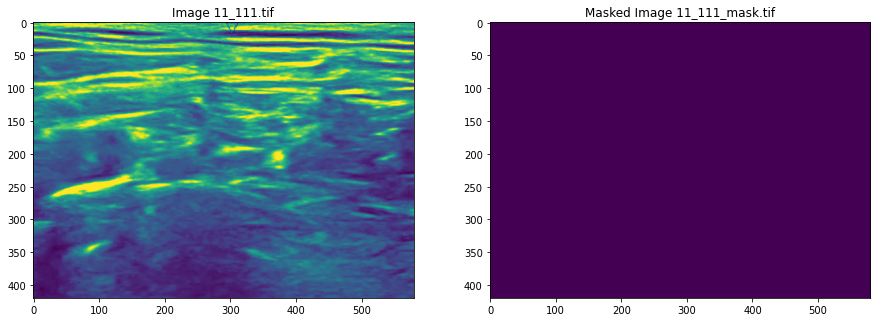

In [ ]:

# Definisanje putanje do podataka za treniranje modela. 
path1 = '/content/train/'
img, mask = LoadData (path1) # Učitavanje modataka u promenljivu, odnosno originalnih slika i maski. 

show_images = 132

img_view  = imageio.imread(path1 + img[show_images]) # Učitavanje jedne originalne slike iz niza slika. 
mask_view = imageio.imread(path1 + mask[show_images]) # Učitavanje jedne maske iz niza maski. 

print(img_view.shape) # Ispisivanje dimenzija slike. 
print(mask_view.shape) # Ispisivanje dimenzija maske.
fig, arr = plt.subplots(1, 2, figsize=(15, 15)) # Plotovanje slike i maske, odakle se vide dimenzije.
arr[0].imshow(img_view) # Prikaz plota slike.
arr[0].set_title('Image ' + img[show_images]) # Postavljanje naslova za plot slike. 
arr[1].imshow(mask_view) # Prikaz plota maske.
arr[1].set_title('Masked Image '+ mask[show_images]) # Postavljanje naslova za plot maske.

**Predprocesuiranje podataka:**

In [ ]:

def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
   
    # Postavljaju se tražene dimenzije slika i maski. 
    m = len(img)                     # Broj slika. 
    i_h,i_w,i_c = target_shape_img   # Postavljanje visine, širine i kanala slike.
    m_h,m_w,m_c = target_shape_mask  # Postavljanje visine, širine i kanala maske.
   
    # X i Y su NumPy nizovi koji sadrže broj slika, i visinu, širinu i kanale slike/maske.
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)
    
    # Promena veličine slika i maski. 
    for file in img: # Prolazi se iterativno kroz img set.

        # Slika se pretvara u niz željene veličine. 

        index = img.index(file) # Uzima se index aktuelne slike.
        path = os.path.join(path1, file) # Postavlja se putanja do aktuelne slike. 
        single_img = Image.open(path).convert('RGB') # Pikseli slike se pretvaraju u 8-bitne RGB vrednosti. 
        single_img = single_img.resize((i_h,i_w)) # Promena veličine slike na željenu veličinu.
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) # Promena sa promenom kanala. 
        single_img = single_img/256.
        X[index] = single_img # Slika se postavlja na index u postojeći X niz.
        
        # Maska se pretvara u niz željene veličine. 
        
        single_mask_ind = mask[index] # Maska na prosleđenom indeksu se uzima za trenutnu 
        path = os.path.join(path1, single_mask_ind) # Pravi se putanja 
        single_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Učitava se maska sa putanje, u crno-beloj varijanti (eng. Grayscale)
         # Vrši se promena veličine slike, sa interpolacijom ("Interpolacija najbližih suseda" - slika se "prilagodjava" novim dimenzijama 
        # tako što se pikseli proširuju po principu da se pozicije oko polja sa nekom vrednošću popunjavaju istom tom vrednošću).
        single_mask = cv2.resize(single_mask, dsize=(m_h, m_w), interpolation=cv2.INTER_NEAREST)
        single_mask = asarray(single_mask) # Pretvaranje u niz.
        single_mask = single_mask[..., tf.newaxis] # Dodaje se dimenzija. 
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c)) # Promena dimenzija maske sa kanalima.  
        single_mask = single_mask/255
        single_mask = single_mask.astype(int) # Pretvara se u integer tip podatka. 
        y[index] = single_mask # U y nizu se aktuelna maska postavlja na prosledjenu poziciju. 
    return X, y # Vraćaju se slika i maska. 

X Shape: (5635, 128, 128, 3)
Y shape: (5635, 128, 128, 1)
[0 1]


Text(0.5, 1.0, 'Processed Masked Image ')

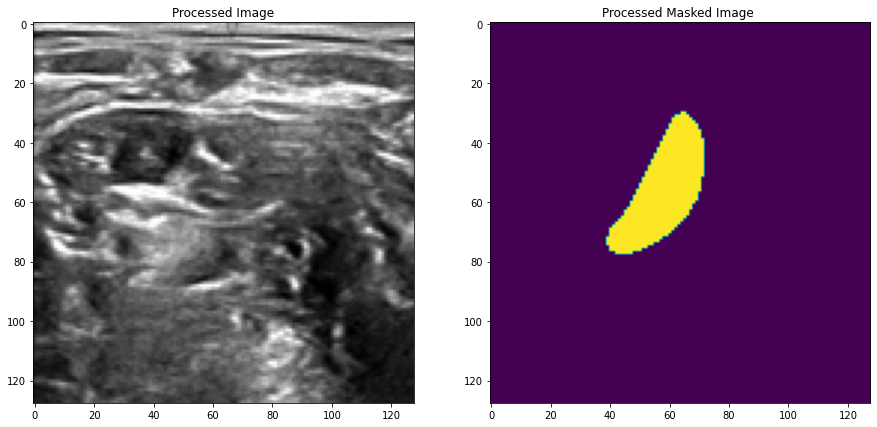

In [ ]:
# Definisanje ciljanih parametara (širina, visina, kanal) za sliku i masku. 
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Poziva se metoda definisana u prethodnom bloku, koja preprocesuira podatke (prosleđuju se parametri uključujući prethodno definisane ciljane parametre).

X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path1)

# Ispisuju se dimenzije nizova X i y koje je vratio prethodni poziv metode. 
print("X Shape:", X.shape)
print("Y shape:", y.shape)

print(np.unique(y))
# Na osnovu ovog ispisa vidi se da postoje dve jedinstvene klase u y nizu: 0 i 1.

# Vizuelizacija rezultata
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15)) # Definicija plotova. 
arr[0].imshow(X[image_index]) # Prikaz slike sa indeksom 0 na plotu.
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0]) # Prikaz maske sa istim indeksom na plotu. 
arr[1].set_title('Processed Masked Image ')

**UNET:**

**Konvolucija:**
## 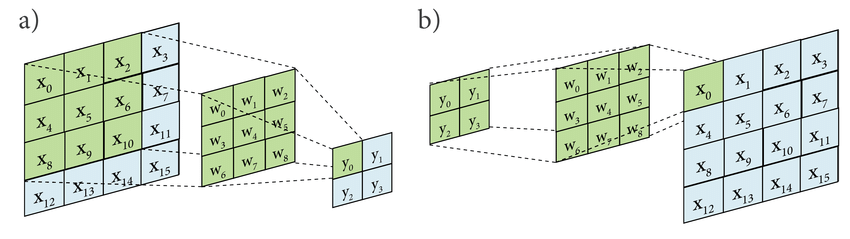 

U matematici, ukratko, rezultat konvolucije je način na koju jedna matrica menja drugu.
U konvolucionalnim neuronskim mrežama, filteri se primenjuju na ulaze kako bi se napravila "aktivacija". Ako se isti filter više puta primeni na ulaz, dobija se mapa aktivacija, odnosno "feature map-a". Ona govori o "jačini" i lokaciji detektovanog "feature-a" u okviru ulaza, kao što je slika. 

Konvolucija zahteva dva parametra: 
1. Dimenzija sa brojem kanala i
2. Broj filtera, odnosno kernela. 

Koristi se sledeća formula:

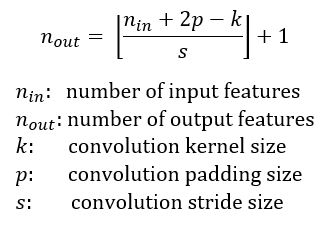


**Max-pooling:**

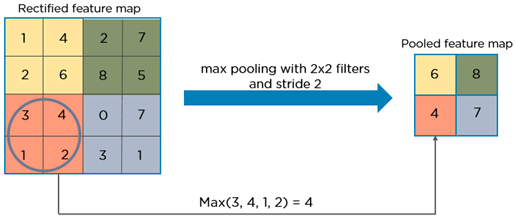

U suštini služi da bi se smanjio broj parametara u mreži tako što se smanjuje feature mapa nastala u okviru konvolucije. 

Kao što se vidi u primeru na slici iznad, iz svake od četiri "podmatrice" dimenzija 4x4 u okviru velike matrice 8x8 uzima se najveća vrednost, čime se na izlazu pravi matrica 4x4 sa tim ekstraktovanim vrednostima. 

**Definisanje enkodera:**

In [ ]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
   

     #EncoderBlock - Dodaju se dva nivoa konvolucije, prosleđuju se parametri za podešavanje algoritma (prosleđeni broj filtera, veličina kernela itd.)
     # kao i prosleđeni ulaz u algoritam. 

    conv = Conv2D(n_filters, #Broj filtera.
                  3,   # Veličina kernela.  
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs) #Ulaz
    conv = Conv2D(n_filters, 
                  3,  
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Normalizacija rezultata konvolucije. 
    conv = BatchNormalization()(conv, training=False)

    # Ispravljanje u slučaju overfitting-a (slučaj da je model previše dobro istreniran isključivo na testne podatke, a ne daje dobre realne predikcije
    # novih podataka).
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling - smanjivanje veličine slike s tim da broj kanala ostaje isti. 
   
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # Rezultat konvolucija bez max_poolinga, kako bi se izbegao gubitak podataka.      
    skip_connection = conv
    
    return next_layer, skip_connection #Vraćanje rezultata.

**Definisanje dekodera:**

In [ ]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
 
# DecoderBlock - koristi konvoluciju da poveća sliku, nakon čega spaja rezultat iz encoder bloka. 

    # Povećava sliku konvolucijom. 
    up = Conv2DTranspose(
                 n_filters,
                 (3,3), 
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Spaja to sa skip_connection-om iz prethodnog bloka da bi izbegao gubitak podataka. 
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Dodaju se još dva nivoa konvolucije, sa sličnim parametrima kao u encoder bloku, s tim da se jednoj konvoluciji prosleđuje prethodno
    # kreirani "merge" kao rezultat, a drugoj konvolucija. 
    conv = Conv2D(n_filters, 
                 3, 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3, 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv # Vraća se rezultirajuća konvolucija 

**Definisanje UNET-a:**

In [ ]:
# Definišemo UNET neuronsku mrežu, sa parametrima: veličina unosa, broj filtera i broj klasa. 

def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=2):
    inputs = Input(input_size)

    # Definisanje blokova neuronske mreže - prvi blok poziva EncoderMiniBlock sa "inputs" kao ulazom, dok svaki sledeći blok poziva prvi element. 
    # prethodnog bloka sa izmenjenim parametrima. 
    # Filteri se povećavaju što idemo dublje u neuronsku mrežu da bi se povećali kanali slike 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 

    # U nastavku se uzastopno poziva dekoder, kom se prosleđuju vrednosti filtera koje se smanjuju u svakom sledećem pozivu. 

    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

   # U nastavku se pravi 3x3 konvolucioni sloj, nakon čega se pravi 1x1 konvolucioni sloj koji menja veličinu slike u željenu. 

    conv9 = Conv2D(n_filters,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Definisanje modela, prosleđivanje ulaza u metodu i rezultata konvolucije kao izlaza. 
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model # Vraćanje definisanog modela. 

**Podela podataka na podatke za treniranje i validacione, i priprema modela:**

In [ ]:
# Podela seta podataka na podatke za trening i podatke za validaciju (korišćenjem Scikit learn biblioteke), gde će za validacione podatke biti uzeto 20% podataka.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

# Pozivanje funkcije koja vraća model i čuvanje rezultata u promenljivoj "unet".
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=2)

# Ispis sumarnih podataka o modelu, može se videti kako se "output" menja kroz iteracije konvolucije. 
# Kao što je rečeno u uvodu, prvo se dimenzije smanjuju dok se broj kanala povećava, u enkoder delu, dok je u dekoder delu obrnuto.
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

**Kompajliranje i treniranje modela:**

In [ ]:
# Kompajliranje UNET modela (sa definisanom funkcijom za optimizaciju, funkcijom gubitka, i preciznošću ("accuracy") kao metrikom koja će se pratiti kroz epohe).
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Treniranje UNET modela - prosleđeni su podaci za treniranje, "batch_size" kao broj primeraka koji će se propagirati kroz neuronsku mrežu, broh epoha 
# treniranja modela, i validacioni podaci za evaluaciju modela. Cilj je da u svakoj novoj epohi "accuracy" bude veći, kada prestane da se povećava ima 
# smisla prekinuti treniranje modela.
# Broj epoha je postavljen na 5 i vidi se napredak "accuracy" metrike kroz epohe.
results = unet.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
141/141 [==============================] - 51s 217ms/step - loss: 0.0882 - accuracy: 0.9812 - val_loss: 0.0392 - val_accuracy: 0.9876
Epoch 2/5
141/141 [==============================] - 26s 184ms/step - loss: 0.0350 - accuracy: 0.9883 - val_loss: 0.0399 - val_accuracy: 0.9877
Epoch 3/5
141/141 [==============================] - 26s 186ms/step - loss: 0.0290 - accuracy: 0.9894 - val_loss: 0.0278 - val_accuracy: 0.9897
Epoch 4/5
141/141 [==============================] - 26s 188ms/step - loss: 0.0273 - accuracy: 0.9897 - val_loss: 0.0265 - val_accuracy: 0.9901
Epoch 5/5
141/141 [==============================] - 27s 189ms/step - loss: 0.0247 - accuracy: 0.9906 - val_loss: 0.0277 - val_accuracy: 0.9904


**Priprema testnih podataka i pravljenje predikcija:**

In [ ]:
# Importovanje seta podataka koji služi za testiranje istreniranog UNET modela. 

path2 = '/content/test/'
image_dataset = os.listdir(path2)
test_img = []
for file in image_dataset:
    test_img.append(file)

In [ ]:

m = len(test_img)                     # Broj slika. 
i_h,i_w,i_c = target_shape_img   # Širina, visina, i kanali slike. 

# Definisanje testnog niza sa brojem slika i dimenzijama jedne slike. 
test_X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)

# Promena veličine slika i maski - analogno preprocesuiranju seta podataka za trening. 
for file in test_img:
    index = test_img.index(file)
    path = os.path.join(path2, file)
    single_img = Image.open(path).convert('RGB')
    single_img = single_img.resize((i_h,i_w))
    single_img = np.reshape(single_img,(i_h,i_w,i_c)) 
    single_img = single_img/256.
    test_X[index] = single_img
    

# Predikcije za maske. 
test_y = []
for img in test_X:
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    test_y.append(pred_mask)

**Enkodiranje i ispis rezultata:**

In [ ]:
# Run Lenght Encoding - algoritam za kompresiju podataka bez gubitaka, koji se zasniva na tome da smanji "runs", odnosno podatke koji se nepotrebno ponavljaju. To radi tako što čuva broj "run-ova" zajedno sa podacima na koje se odnose. 

def rle_encoding(x):
  
    dots = np.where(x.T.flatten()==1)[0] 
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

# Importovanje Pandas biblioteke zbog potrebe za korišćenjem Dataframe-a iz nje. 
import pandas as pd
#Definisanje dataframe-a, kolone su "img" - slika, i "pixels" - pikseli
test_output = pd.DataFrame(columns = ['img','pixels'])

# Za svaku stavku u nizu sa testnim podacima...
for i,item in enumerate(test_y):

  # Radi se RLE enkodiranje stavke iz dataseta, pretvorene u numpy niz.
    encoding = rle_encoding(item.numpy())

# "pixels" promenljiva se definiše kao rezultati enkodiranja odvojeni razmakom. 
    pixels = ' '.join(map(str, encoding))

    # Definiše se dataframe, gde je img broj u nazivu slike iz dataset-a za treniranje, a "pixels" je prethodno definisani niz.
    df = {'img': test_img[i][:-4], 'pixels': pixels}

    # Priprema ispisa rezultata, na osnovu prethodno definisanog DataFrame-a ("df").
    test_output = test_output.append(df, ignore_index = True)

# Finalni ispis rezultata - za svaku sliku su navedeni pikseli koji su klasifikovani kao 1, odnosno oni na kojima je predikcija da se nalazi nervna struktura,
# dok je klasa 0 data pikselima za koje je predikcija da ne predstavljaju nervnu strukturu.
test_output

,img,pixels
0,1696,
1,4555,
2,240,7208 6 7331 1 7335 9 7454 19 7582 20 7709 21 7...
3,760,
4,3674,8742 7 8750 1 8860 4 8867 14 8986 25 9114 26 9...
...,...,...
5503,3662,
5504,4907,9773 3 9901 3 10028 1 10031 1 10157 1 10159 1 ...
5505,5013,
5506,4296,9522 1 9650 1 9774 1 9894 1 9896 7 10022 9 100...


**Zaključak:**

Zaključak je da je UNET revolucionarna neuronska mreža koja i te kako ima svoju use case-ove u realnom svetu, pogotovo u biomedicini za koju je inicijalno i projektovana.
Projekti koji koriste konvolucionalne neuronske mreže za segmentaciju slika u oblasti biomedicine imaju i veliku etičku vrednost, jer mogu značajno pomoći ljudima koji se nađu u situaciji 
da segmentacija slika može znatno da smanji bol ili čak šanse da prežive neke zahvate ako se rezultati segmentacije pravilno iskoriste i primene. Zatim ovakve mreže imaju i veliku ulogu u potencijalnom spašavanju života detekcijom 
kancera na slikama nastalim kao rezultat medicinskih istraživanja pacijenata sa simptomima. Zbog toga je ova oblast i te kako vredna pažnje, i definitivno 
u budućnosti postoji prostor u kom će biti dodatno istraživana, razvijana i implementirana. 

**Literatura:** 


*   U-Net: Convolutional Networks for Biomedical
Image Segmentation,
Olaf Ronneberger, Philipp Fischer, and Thomas Brox
*   https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5


*   https://en.wikipedia.org/wiki/U-Net
*   https://developers.arcgis.com/python/guide/how-unet-works/


*   https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
*   https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939

*  https://paperswithcode.com/method/u-net








